## Libraries and versions

### Libraries

In [1]:
python_version = !Python -V #version 3.7.9
import pandas as pd #version 1.2.3
import numpy as np #version 1.19.2
import seaborn as sns #0.11.0
from matplotlib import __version__ as plt_version, pyplot as plt #3.3.3

#for machine learning models
#pre processing
from category_encoders import OrdinalEncoder, __version__ as ce_version #version 2.2.2
#version
from sklearn import __version__ as sk_version #version 0.24.1
#split data in train and test
from sklearn.model_selection import train_test_split
#classificators
from sklearn.ensemble import RandomForestClassifier
#metrics
from sklearn.metrics import accuracy_score

#for contingency table
import statsmodels.api as sm

#baseline for new segmentation
from sklearn.dummy import DummyClassifier

### Versions

In [2]:
print(f'{python_version[0]}')
print(f'Pandas version: {pd.__version__}')
print(f'Numpy version: {np.__version__}')
print(f'Category Encoders version: {ce_version}')
print(f'Sklearn version: {sk_version}')
print(f'Seaborn version: {sns.__version__}')
print(f'Matplotlib version: {plt_version}')

Python 3.7.9
Pandas version: 1.2.3
Numpy version: 1.19.2
Category Encoders version: 2.2.2
Sklearn version: 0.24.1
Seaborn version: 0.11.0
Matplotlib version: 3.3.3


## Configurations

In [3]:
import warnings
warnings.filterwarnings("ignore")

#seaborn graphics
sns.set_style('darkgrid')
sns.set_palette('Accent')

## Dataset

In [4]:
dataset = pd.read_csv('train_cleaning.csv')

In [5]:
dataset.head()

,ID,Gender,Ever_Married,Age,Graduated,Profession,Work_Experience,Spending_Score,Family_Size,Var_1,Segmentation
0,462809,Male,No,22,No,Healthcare,1.0,Low,4.0,Cat_4,D
1,462643,Female,Yes,38,Yes,Engineer,1.0,Average,3.0,Cat_4,A
2,466315,Female,Yes,67,Yes,Engineer,1.0,Low,1.0,Cat_6,B
3,461735,Male,Yes,67,Yes,Lawyer,0.0,High,2.0,Cat_6,B
4,462669,Female,Yes,40,Yes,Entertainment,1.0,High,6.0,Cat_6,A


## make model better

OPTIONS

- change parameters
- change dependent variables

# Dataset transformation

## Encoders

### OrdinalEncoder

In [6]:
#OrdinalEncoder transform dataset using a map for each variable
map_encoders = [
    {'col':'Gender', 'mapping':{'Female':0, 'Male':1}},   
    {'col':'Ever_Married','mapping':{'No':0, 'Yes':1}},
    {'col':'Graduated','mapping':{'No':0, 'Yes':1}},
    {'col':'Profession','mapping':{'Homemaker':0, 'Doctor':4, 'Marketing':1, 'Healthcare':7, 'Entertainment':6,
                                   'Engineer':5, 'Artist':8, 'Lawyer':3, 'Executive':2}},
    {'col':'Spending_Score','mapping':{'Low':0, 'Average':1, 'High':2}},
    {'col':'Var_1','mapping':{'Cat_1':1, 'Cat_2':3, 'Cat_3':4, 'Cat_4':5, 'Cat_5':0, 'Cat_6':6, 'Cat_7':2}},
    {'col': 'Segmentation', 'mapping':{'A':0, 'B':1, 'C':2, 'D':3}}
]
encoder = OrdinalEncoder(cols=['Gender','Ever_Married', 'Graduated','Profession', 'Spending_Score', 'Var_1', 'Segmentation'],
                        mapping=map_encoders)
dataset_ordinal = encoder.fit_transform(dataset)

#drop non used columns ID, Gender and Family_Size
dataset_ordinal.drop(columns=['ID', 'Family_Size'], inplace=True)

## Variables

### OrdinalEncoder

In [7]:
X_ordinal = dataset_ordinal[['Ever_Married', 'Age', 'Graduated', 'Profession', 'Work_Experience', 'Spending_Score', 'Var_1']]
y_ordinal = dataset_ordinal['Segmentation']

## model6 - test6

In [8]:
#first - split train and test data
accuracy_list = []
iterations = 1
for iter in range(0, iterations):
    X_train, X_test, y_train, y_test = train_test_split(X_ordinal, y_ordinal, train_size=0.7, stratify=y_ordinal)

    #third - macinhe learning apply
    model6 = RandomForestClassifier(max_depth=4, min_samples_leaf=30, class_weight='balanced')
    model6.fit(X_train, y_train)
    y_predict = model6.predict(X_test)

    #fourth - test accuray
    accuracy = accuracy_score(y_test, y_predict)
    accuracy_list.append(accuracy)

max_accuracy = np.asarray(accuracy_list).max()
mean_accuracy = np.asarray(accuracy_list).mean()
min_accuracy = np.asarray(accuracy_list).min()
std_accuracy = np.asarray(accuracy_list).std()
print(f'ACCURACY FOR {iterations} ITERATIONS')
print(f'Max = {max_accuracy:.4f}\nMean = {mean_accuracy:.4f}\nMin = {min_accuracy:.4f}\nStd = {std_accuracy:.4f}')
print(model6.set_params())

ACCURACY FOR 1 ITERATIONS
Max = 0.5337
Mean = 0.5337
Min = 0.5337
Std = 0.0000
RandomForestClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=30)


In [9]:
importance = model6.feature_importances_
pd.DataFrame(data={'Importance':importance}, index=X_ordinal.columns)

,Importance
Ever_Married,0.124212
Age,0.322730
Graduated,0.095960
Profession,0.201132
Work_Experience,0.012995
Spending_Score,0.226656
Var_1,0.016315


## First step: analyse error

### Error for Segmentation

In [10]:
#create DataFrame with errors
dict_compare = {'Real':y_test.values, 'Predict':y_predict}
dataset_error = pd.DataFrame(dict_compare, index=y_test.index)
dataset_error['Error'] = dataset_error['Real'] !=dataset_error['Predict']
dataset_error['Cat_Real'] = dataset_error['Real'].map({0:'A', 1:'B', 2:'C', 3:'D'})
dataset_error['Cat_Predict'] = dataset_error['Predict'].map({0:'A', 1:'B', 2:'C', 3:'D'})

In [11]:
print('Total error for Real Segmentation')
dataset_error.query('Error==True')['Cat_Real'].value_counts(normalize=True)

Total error for Real Segmentation


B    0.344828
A    0.267474
C    0.218080
D    0.169618
Name: Cat_Real, dtype: float64

In [12]:
print('Total correct for Real Segmentation')
dataset_error.query('Error==False')['Cat_Real'].value_counts(normalize=True)

Total correct for Real Segmentation


D    0.371336
C    0.272801
A    0.222313
B    0.133550
Name: Cat_Real, dtype: float64

In [13]:
print('Percent of Error for each Segmentation')
pd.crosstab(index=dataset_error['Cat_Real'], columns=dataset_error['Error'], normalize='index')

Percent of Error for each Segmentation


Error,False,True
Cat_Real,,
A,0.487500,0.512500
B,0.307116,0.692884
C,0.588752,0.411248
D,0.714734,0.285266


- the model did not understand the features for some Segmentations, particularlly for B and A
- the proportion of Segmentation in train sample is the same of total data
- what is different for these Segmentations?

## Contingecy table

### Ever_Married

In [14]:
table_ever = sm.stats.Table.from_data(dataset[['Ever_Married', 'Segmentation']])

In [15]:
print('Estimatives for independecy')
table_ever.fittedvalues

Estimatives for independecy


Segmentation,A,B,C,D
Ever_Married,,,,
No,773.433173,736.977833,785.446864,881.142131
Yes,1093.566827,1042.022167,1110.553136,1245.857869


In [16]:
print('Original values')
table_ever.table_orig

Original values


Segmentation,A,B,C,D
Ever_Married,,,,
No,776,468,381,1552
Yes,1091,1311,1515,575


In [17]:
print(table_ever.test_nominal_association())

df          3
pvalue      0.0
statistic   1395.1646743205733


### Graduated

In [18]:
table_graduated = sm.stats.Table.from_data(dataset[['Graduated', 'Segmentation']])

In [19]:
print('Estimatives for independecy')
table_graduated.fittedvalues

Estimatives for independecy


Segmentation,A,B,C,D
Graduated,,,,
No,695.286478,662.514539,706.086322,792.112661
Yes,1171.713522,1116.485461,1189.913678,1334.887339


In [20]:
print('Original values')
table_graduated.table_orig

Original values


Segmentation,A,B,C,D
Graduated,,,,
No,689,494,324,1349
Yes,1178,1285,1572,778


In [21]:
print(table_graduated.test_nominal_association())

df          3
pvalue      0.0
statistic   1021.6728101651402


### Gender

In [22]:
table_gender = sm.stats.Table.from_data(dataset[['Gender', 'Segmentation']])

In [23]:
print('Estimatives for independecy')
table_gender.fittedvalues

Estimatives for independecy


Segmentation,A,B,C,D
Gender,,,,
Female,840.381275,800.770374,853.434868,957.413483
Male,1026.618725,978.229626,1042.565132,1169.586517


In [24]:
print('Original values')
table_gender.table_orig

Original values


Segmentation,A,B,C,D
Gender,,,,
Female,856,825,881,890
Male,1011,954,1015,1237


In [25]:
print(table_gender.test_nominal_association())

df          3
pvalue      0.007007002742882573
statistic   12.11266903892659


### Spending_Score

In [26]:
table_spending = sm.stats.Table.from_data(dataset[['Spending_Score', 'Segmentation']])

In [27]:
print('Estimatives for independecy')
table_spending.fittedvalues

Estimatives for independecy


Segmentation,A,B,C,D
Spending_Score,,,,
Average,455.977442,434.485200,463.060112,519.477246
High,280.208241,267.000782,284.560699,319.230278
Low,1130.814317,1077.514017,1148.379189,1288.292476


In [28]:
print('Original values')
table_spending.table_orig

Original values


Segmentation,A,B,C,D
Spending_Score,,,,
Average,315,559,873,126
High,255,368,399,129
Low,1297,852,624,1872


In [29]:
print(table_spending.test_ordinal_association())

null_mean   16272.112661363934
null_sd     84.30044016405724
pvalue      2.7550359802155252e-17
statistic   16985.0
zscore      8.456507904925706


### Profession

In [30]:
table_profession = sm.stats.Table.from_data(dataset[['Profession', 'Segmentation']])

In [31]:
print('Estimatives for independecy')
table_profession.fittedvalues

Estimatives for independecy


Segmentation,A,B,C,D
Profession,,,,
Artist,596.203286,568.101578,605.464076,679.231060
Doctor,162.623028,154.957882,165.149042,185.270048
Engineer,164.083714,156.349720,166.632416,186.934150
Entertainment,223.728387,213.183075,227.203547,254.884992
Executive,140.712740,134.080323,142.898422,160.308515
Healthcare,309.421959,294.837528,314.228191,352.512322
Homemaker,56.966749,54.281653,57.851610,64.899987
Lawyer,145.581693,138.719781,147.843004,165.855522
Marketing,67.678446,64.488460,68.729691,77.103403


In [32]:
print('Original values')
table_profession.table_orig

Original values


Segmentation,A,B,C,D
Profession,,,,
Artist,546,730,1038,135
Doctor,190,140,138,200
Engineer,249,181,73,171
Entertainment,354,213,144,208
Executive,117,176,175,110
Healthcare,105,99,134,933
Homemaker,69,53,26,86
Lawyer,185,157,135,121
Marketing,52,30,33,163


In [33]:
print(table_graduated.test_nominal_association())

df          3
pvalue      0.0
statistic   1021.6728101651402


### Var_1

In [34]:
table_var1 = sm.stats.Table.from_data(dataset[['Var_1', 'Segmentation']])

In [35]:
print('Estimatives for independecy')
table_var1.fittedvalues

Estimatives for independecy


Segmentation,A,B,C,D
Var_1,,,,
Cat_1,30.917851,29.460555,31.398096,35.223497
Cat_2,98.596297,93.949016,100.127787,112.326901
Cat_3,185.263659,176.531360,188.141348,211.063633
Cat_4,247.099361,235.452471,250.937541,281.510627
Cat_5,19.719259,18.789803,20.025557,22.465380
Cat_6,1238.661625,1180.278002,1257.901682,1411.158691
Cat_7,46.741948,44.538793,47.467988,53.251271


In [36]:
print('Original values')
table_var1.table_orig

Original values


Segmentation,A,B,C,D
Var_1,,,,
Cat_1,29,25,26,47
Cat_2,82,99,94,130
Cat_3,201,179,141,240
Cat_4,314,217,103,381
Cat_5,18,20,18,25
Cat_6,1176,1197,1469,1246
Cat_7,47,42,45,58


In [37]:
print(table_var1.test_ordinal_association())

null_mean   49696.88042769592
null_sd     140.85838321806077
pvalue      0.09541633097998235
statistic   49462.0
zscore      -1.6674934237481984


- only results for Var_1 had a pvalue 0.09, which means that variable is independent for Segmentation; this variable will be exclude from model
- when I did not imput Var_1 in model the mean accuracy is the same, but the model understand more the differences between Segmentations  
- Segmentation B increase the accuracy

### Work_Experience

In [38]:
table_work = sm.stats.Table.from_data(dataset[['Work_Experience', 'Segmentation']])

In [39]:
print('Statistc test for ordinal data')
print(table_work.test_ordinal_association())

Statistc test for ordinal data
null_mean   29559.73190768027
null_sd     325.1875360013917
pvalue      0.6819385886823095
statistic   29693.0
zscore      0.40981918913140364


### Age

In [40]:
table_age = sm.stats.Table.from_data(dataset[['Age', 'Segmentation']])

In [41]:
print('Statistc test for ordinal data')
print(table_age.test_ordinal_association())

Statistc test for ordinal data
null_mean   276655.5264050072
null_sd     1513.2954623815967
pvalue      4.883481607805572e-97
statistic   245021.0
zscore      -20.904395203314316


- the pvalue for numeric ordinal variables 'Age' and 'Work_Experience' is very different for each one: for Age pvalue is very close to zero and for Work_Experience is very bigger then 0.05, which rejected null hipotesys
- I will exclude Work_Experience from classification model

## New Variables

### OrdinalEncoder

In [42]:
X_ordinal_new = dataset_ordinal[['Ever_Married', 'Age', 'Graduated', 'Profession', 'Spending_Score']]
y_ordinal_new = dataset_ordinal['Segmentation']

## model6_1 - test3 change variables

In [43]:
#first - split train and test data
accuracy_list = []
iterations = 1
for iter in range(0, iterations):
    X_train, X_test, y_train, y_test = train_test_split(X_ordinal_new, y_ordinal_new, train_size=0.7, stratify=y_ordinal)

    #third - macinhe learning apply
    model6_1 = RandomForestClassifier(max_depth=4, min_samples_leaf=30, class_weight='balanced')
    model6_1.fit(X_train, y_train)
    y_predict = model6_1.predict(X_test)

    #fourth - test accuray
    accuracy = accuracy_score(y_test, y_predict)
    accuracy_list.append(accuracy)

max_accuracy = np.asarray(accuracy_list).max()
mean_accuracy = np.asarray(accuracy_list).mean()
min_accuracy = np.asarray(accuracy_list).min()
std_accuracy = np.asarray(accuracy_list).std()
print(f'ACCURACY FOR {iterations} ITERATIONS')
print(f'Max = {max_accuracy:.4f}\nMean = {mean_accuracy:.4f}\nMin = {min_accuracy:.4f}\nStd = {std_accuracy:.4f}')
print(model6_1.set_params())

ACCURACY FOR 1 ITERATIONS
Max = 0.5067
Mean = 0.5067
Min = 0.5067
Std = 0.0000
RandomForestClassifier(class_weight='balanced', max_depth=4,
                       min_samples_leaf=30)


### Ckeck results

In [44]:
#create DataFrame with errors
dict_compare = {'Real':y_test.values, 'Predict':y_predict}
dataset_error = pd.DataFrame(dict_compare, index=y_test.index)
dataset_error['Error'] = dataset_error['Real'] !=dataset_error['Predict']
dataset_error['Cat_Real'] = dataset_error['Real'].map({0:'A', 1:'B', 2:'C', 3:'D'})
dataset_error['Cat_Predict'] = dataset_error['Predict'].map({0:'A', 1:'B', 2:'C', 3:'D'})

In [45]:
print('Percent of Error for each Segmentation')
pd.crosstab(index=dataset_error['Cat_Real'], columns=dataset_error['Error'], normalize='index')

Percent of Error for each Segmentation


Error,False,True
Cat_Real,,
A,0.462500,0.537500
B,0.295880,0.704120
C,0.567663,0.432337
D,0.667712,0.332288


- the model could not understand Segmentation B

### look outputs

In [46]:
print('Importance per feature')
pd.DataFrame(data={'Importance':model6_1.feature_importances_}, index=X_ordinal_new.columns)

Importance per feature


,Importance
Ever_Married,0.088546
Age,0.385167
Graduated,0.079587
Profession,0.237220
Spending_Score,0.209479


- 40% of decisions was made based in Age
- Age for Segmentation B is not much different for C and A
- Seems important see this variable much closer

### Age Boxplot for Segmentation

Text(0.5, 1.0, 'Graphic 1 - Boxplot for Segmentation')

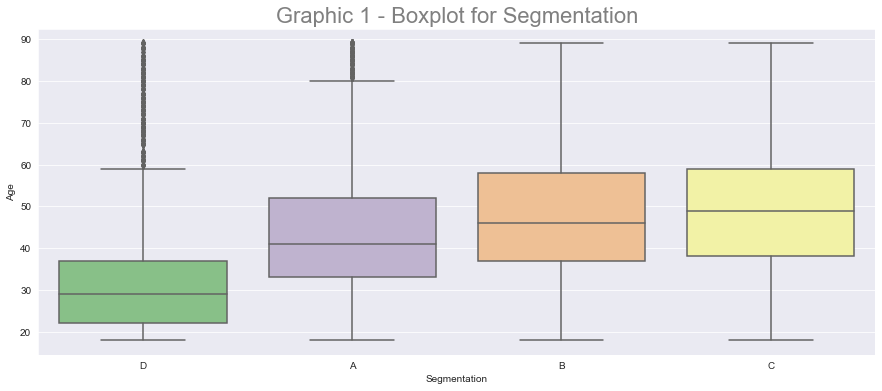

In [47]:
graphic1 = sns.boxplot(y=dataset['Age'], x=dataset['Segmentation'])
graphic1.figure.set_size_inches(15,6)
graphic1.set_title('Graphic 1 - Boxplot for Segmentation', fontsize=22, color='gray')

Text(0.5, 1.0, 'D')

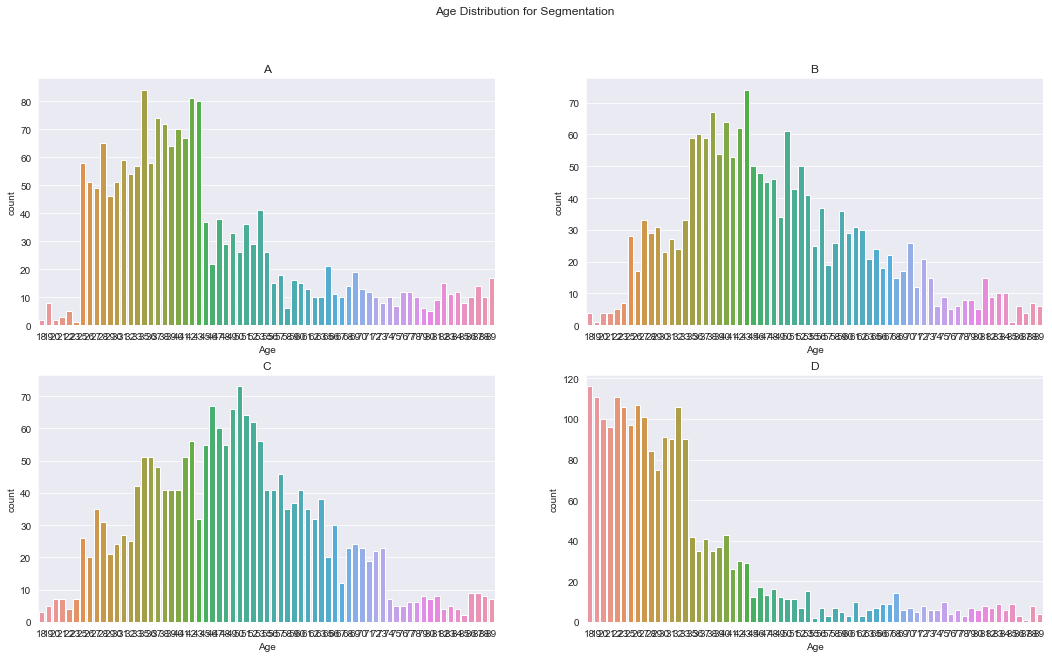

In [48]:
fig, axes = plt.subplots(2,2, figsize=(18,10))
fig.suptitle('Age Distribution for Segmentation')

#Segmentation A
sns.countplot(ax=axes[0,0], data=dataset.query('Segmentation=="A"'), x='Age')
axes[0,0].set_title('A')
#Segmentation B
sns.countplot(ax=axes[0,1], data=dataset.query('Segmentation=="B"'), x='Age')
axes[0,1].set_title('B')
#Segmentation C
sns.countplot(ax=axes[1,0], data=dataset.query('Segmentation=="C"'), x='Age')
axes[1,0].set_title('C')
#Segmentation D
sns.countplot(ax=axes[1,1], data=dataset.query('Segmentation=="D"'), x='Age')
axes[1,1].set_title('D')

- Segmentation D is more easy to understand because there are very diferentiation in Age (median is 15 years low)
- I need to create a diferentiation for Segmentation B in variable Age
- I need to decrease the weight of Age in model; solution is create some categories of age

### Age categories

In [49]:
#iteration for split age in categories
age_array = dataset['Age'].values
age_list = []
for age in age_array:
    if age >75:
        age_list.append(12)
    elif age >=71 and age <=75:
        age_list.append(11)
    elif age >=66 and age <=70:
        age_list.append(10)
    elif age >=61 and age <=65:
        age_list.append(9)
    elif age >=56 and age <=60:
        age_list.append(8)
    elif age >=51 and age <=55:
        age_list.append(7)
    elif age >=46 and age <=50:
        age_list.append(6)
    elif age >=41 and age <=45:
        age_list.append(5)
    elif age >=36 and age <=40:
        age_list.append(4)
    elif age >=31 and age <=35:
        age_list.append(3)
    elif age >=26 and age <=30:
        age_list.append(2)
    else:
        age_list.append(1)

#create variables in dataset
dataset['age_value_categories'] = np.asarray(age_list)
age_categories = {1:'18-25', 2:'26-30', 3:'31-35', 4:'36-40', 5:'41-45', 6:'46-50', 
              7:'51-55', 8:'56-60', 9:'61-65', 10:'66-70', 11:'71-75', 12:'75+'}
dataset['age_categories'] = dataset['age_value_categories'].map(age_categories)

Text(0.5, 1.0, 'D')

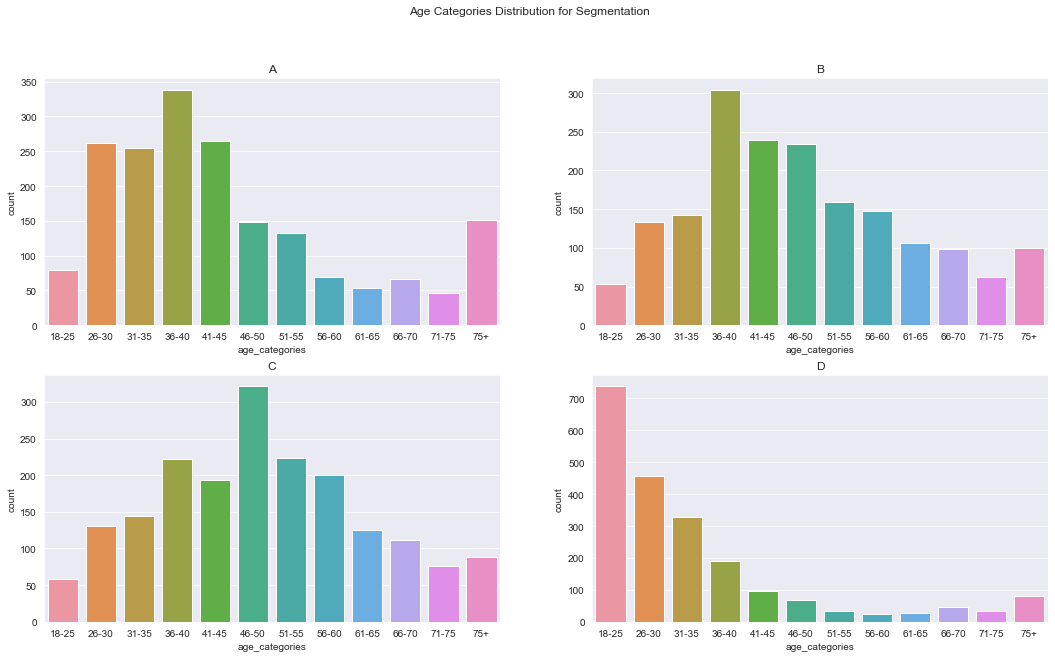

In [50]:
fig, axes = plt.subplots(2,2, figsize=(18,10))
fig.suptitle('Age Categories Distribution for Segmentation')

#Segmentation A
sns.countplot(ax=axes[0,0], data=dataset.query('Segmentation=="A"'), x='age_categories', 
              order=list(age_categories.values()))
axes[0,0].set_title('A')
#Segmentation B
sns.countplot(ax=axes[0,1], data=dataset.query('Segmentation=="B"'), x='age_categories',
             order=list(age_categories.values()))
axes[0,1].set_title('B')
#Segmentation C
sns.countplot(ax=axes[1,0], data=dataset.query('Segmentation=="C"'), x='age_categories',
             order=list(age_categories.values()))
axes[1,0].set_title('C')
#Segmentation D
sns.countplot(ax=axes[1,1], data=dataset.query('Segmentation=="D"'), x='age_categories',
             order=list(age_categories.values()))
axes[1,1].set_title('D')

## model6_2 - test6, change variables and age categories

### Ordinal Encoder

In [51]:
#add variable age_value_categories in dataset_ordinal
dataset_ordinal['age_value_categories'] = dataset['age_value_categories']

X_ordinal_new2 = dataset_ordinal[['Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'age_value_categories']]
y_ordinal_new2 = dataset_ordinal['Segmentation']

In [52]:
#first - split train and test data
accuracy_list = []
iterations = 1
for iter in range(0, iterations):
    X_train, X_test, y_train, y_test = train_test_split(X_ordinal_new2, y_ordinal_new2, train_size=0.7, 
                                                        stratify=y_ordinal_new2)

    #third - macinhe learning apply
    model6_2 = RandomForestClassifier(max_depth=4, min_samples_leaf=30)
    model6_2.fit(X_train, y_train)
    y_predict = model6_2.predict(X_test)

    #fourth - test accuray
    accuracy = accuracy_score(y_test, y_predict)
    accuracy_list.append(accuracy)

max_accuracy = np.asarray(accuracy_list).max()
mean_accuracy = np.asarray(accuracy_list).mean()
min_accuracy = np.asarray(accuracy_list).min()
std_accuracy = np.asarray(accuracy_list).std()
print(f'ACCURACY FOR {iterations} ITERATIONS')
print(f'Max = {max_accuracy:.4f}\nMean = {mean_accuracy:.4f}\nMin = {min_accuracy:.4f}\nStd = {std_accuracy:.4f}')
print(model6_2.set_params())

ACCURACY FOR 1 ITERATIONS
Max = 0.5185
Mean = 0.5185
Min = 0.5185
Std = 0.0000
RandomForestClassifier(max_depth=4, min_samples_leaf=30)


In [53]:
#create DataFrame with errors
dict_compare = {'Real':y_test.values, 'Predict':y_predict}
dataset_error = pd.DataFrame(dict_compare, index=y_test.index)
dataset_error['Error'] = dataset_error['Real'] !=dataset_error['Predict']
dataset_error['Cat_Real'] = dataset_error['Real'].map({0:'A', 1:'B', 2:'C', 3:'D'})
dataset_error['Cat_Predict'] = dataset_error['Predict'].map({0:'A', 1:'B', 2:'C', 3:'D'})

In [54]:
print('Percent of Error for each Segmentation')
pd.crosstab(index=dataset_error['Cat_Real'], columns=dataset_error['Error'], normalize='index')

Percent of Error for each Segmentation


Error,False,True
Cat_Real,,
A,0.467857,0.532143
B,0.299625,0.700375
C,0.565905,0.434095
D,0.703762,0.296238


In [55]:
pd.DataFrame(data={'Importance':model6_2.feature_importances_}, index=X_ordinal_new2.columns)

,Importance
Ever_Married,0.111677
Graduated,0.089590
Profession,0.251517
Spending_Score,0.203803
age_value_categories,0.343414


## model6_3 - test6, change variables, age categories parameters

In [56]:
#first - split train and test data
accuracy_list = []
iterations = 1
for iter in range(0, iterations):
    X_train, X_test, y_train, y_test = train_test_split(X_ordinal_new2, y_ordinal_new2, train_size=0.7, 
                                                        stratify=y_ordinal_new2)

    #third - macinhe learning apply
    model6_3 = RandomForestClassifier(n_estimators=500, max_depth=5, class_weight='balanced', min_samples_leaf=30)
    model6_3.fit(X_train, y_train)
    y_predict = model6_3.predict(X_test)

    #fourth - test accuray
    accuracy = accuracy_score(y_test, y_predict)
    accuracy_list.append(accuracy)

max_accuracy = np.asarray(accuracy_list).max()
mean_accuracy = np.asarray(accuracy_list).mean()
min_accuracy = np.asarray(accuracy_list).min()
std_accuracy = np.asarray(accuracy_list).std()
print(f'ACCURACY FOR {iterations} ITERATIONS')
print(f'Max = {max_accuracy:.4f}\nMean = {mean_accuracy:.4f}\nMin = {min_accuracy:.4f}\nStd = {std_accuracy:.4f}')
print(model6_3.set_params())

ACCURACY FOR 1 ITERATIONS
Max = 0.5037
Mean = 0.5037
Min = 0.5037
Std = 0.0000
RandomForestClassifier(class_weight='balanced', max_depth=5,
                       min_samples_leaf=30, n_estimators=500)


In [57]:
#create DataFrame with errors
dict_compare = {'Real':y_test.values, 'Predict':y_predict}
dataset_error = pd.DataFrame(dict_compare, index=y_test.index)
dataset_error['Error'] = dataset_error['Real'] !=dataset_error['Predict']
dataset_error['Cat_Real'] = dataset_error['Real'].map({0:'A', 1:'B', 2:'C', 3:'D'})
dataset_error['Cat_Predict'] = dataset_error['Predict'].map({0:'A', 1:'B', 2:'C', 3:'D'})

In [58]:
print('Percent of Error for each Segmentation')
pd.crosstab(index=dataset_error['Cat_Real'], columns=dataset_error['Error'], normalize='index')

Percent of Error for each Segmentation


Error,False,True
Cat_Real,,
A,0.471429,0.528571
B,0.320225,0.679775
C,0.543058,0.456942
D,0.650470,0.349530


In [59]:
pd.DataFrame(data={'Importance':model6_3.feature_importances_}, index=X_ordinal_new2.columns)

,Importance
Ever_Married,0.125356
Graduated,0.090209
Profession,0.258575
Spending_Score,0.184283
age_value_categories,0.341577


## model6_4 - test6, change variables, age categories, parameters and change segmentation

In [60]:
dataset_ordinal['Segmentetation_new'] = dataset_ordinal['Segmentation'].map({0:0, 1:1, 2:1, 3:3})

In [61]:
X_ordinal_new3 = dataset_ordinal[['Ever_Married', 'Graduated', 'Profession', 'Spending_Score', 'age_value_categories']]
y_ordinal_new3 = dataset_ordinal['Segmentetation_new']

In [62]:
#first - split train and test data
accuracy_list = []
iterations = 1
for iter in range(0, iterations):
    X_train, X_test, y_train, y_test = train_test_split(X_ordinal_new3, y_ordinal_new3, train_size=0.7, 
                                                        stratify=y_ordinal_new3)

    #third - macinhe learning apply
    model6_4 = RandomForestClassifier(n_estimators=500, max_depth=6, class_weight='balanced')
    model6_4.fit(X_train, y_train)
    y_predict = model6_4.predict(X_test)

    #fourth - test accuray
    accuracy = accuracy_score(y_test, y_predict)
    accuracy_list.append(accuracy)

max_accuracy = np.asarray(accuracy_list).max()
mean_accuracy = np.asarray(accuracy_list).mean()
min_accuracy = np.asarray(accuracy_list).min()
std_accuracy = np.asarray(accuracy_list).std()
print(f'ACCURACY FOR {iterations} ITERATIONS')
print(f'Max = {max_accuracy:.4f}\nMean = {mean_accuracy:.4f}\nMin = {min_accuracy:.4f}\nStd = {std_accuracy:.4f}')
print(model6_4.set_params())

ACCURACY FOR 1 ITERATIONS
Max = 0.6341
Mean = 0.6341
Min = 0.6341
Std = 0.0000
RandomForestClassifier(class_weight='balanced', max_depth=6, n_estimators=500)


In [63]:
#create DataFrame with errors
dict_compare = {'Real':y_test.values, 'Predict':y_predict}
dataset_error = pd.DataFrame(dict_compare, index=y_test.index)
dataset_error['Error'] = dataset_error['Real'] !=dataset_error['Predict']
dataset_error['Cat_Real'] = dataset_error['Real'].map({0:'A', 1:'B', 2:'C', 3:'D'})
dataset_error['Cat_Predict'] = dataset_error['Predict'].map({0:'A', 1:'B', 2:'C', 3:'D'})

In [64]:
print('Percent of Error for each Segmentation')
pd.crosstab(index=dataset_error['Cat_Real'], columns=dataset_error['Error'], normalize='index')

Percent of Error for each Segmentation


Error,False,True
Cat_Real,,
A,0.533929,0.466071
B,0.661831,0.338169
D,0.673981,0.326019


In [65]:
pd.DataFrame(data={'Importance':model6_4.feature_importances_}, index=X_ordinal_new2.columns)

,Importance
Ever_Married,0.101641
Graduated,0.090623
Profession,0.262380
Spending_Score,0.185499
age_value_categories,0.359857


### Dummy Classifier

In [66]:
#first - split train and test data
accuracy_list = []
iterations = 1
for iter in range(0, iterations):
    X_train, X_test, y_train, y_test = train_test_split(X_ordinal_new3, y_ordinal_new3, train_size=0.7, 
                                                        stratify=y_ordinal_new3)

    #third - macinhe learning apply
    dummy = DummyClassifier()
    dummy.fit(X_train, y_train)
    y_predict = dummy.predict(X_test)

    #fourth - test accuray
    accuracy = accuracy_score(y_test, y_predict)
    accuracy_list.append(accuracy)

max_accuracy = np.asarray(accuracy_list).max()
mean_accuracy = np.asarray(accuracy_list).mean()
min_accuracy = np.asarray(accuracy_list).min()
std_accuracy = np.asarray(accuracy_list).std()
print(f'ACCURACY FOR {iterations} ITERATIONS')
print(f'Max = {max_accuracy:.4f}\nMean = {mean_accuracy:.4f}\nMin = {min_accuracy:.4f}\nStd = {std_accuracy:.4f}')
print(dummy.set_params())

ACCURACY FOR 1 ITERATIONS
Max = 0.4794
Mean = 0.4794
Min = 0.4794
Std = 0.0000
DummyClassifier()


In [67]:
#create DataFrame with errors
dict_compare = {'Real':y_test.values, 'Predict':y_predict}
dataset_error = pd.DataFrame(dict_compare, index=y_test.index)
dataset_error['Error'] = dataset_error['Real'] !=dataset_error['Predict']
dataset_error['Cat_Real'] = dataset_error['Real'].map({0:'A', 1:'B', 2:'C', 3:'D'})
dataset_error['Cat_Predict'] = dataset_error['Predict'].map({0:'A', 1:'B', 2:'C', 3:'D'})

In [68]:
print('Percent of Error for each Segmentation')
pd.crosstab(index=dataset_error['Cat_Real'], columns=dataset_error['Error'], normalize='index')

Percent of Error for each Segmentation


Error,False,True
Cat_Real,,
A,0.0,1.0
B,1.0,0.0
D,0.0,1.0


## Conclusions

- some scenarios were tested and the overall accuracy did not show significant improvements, but model1_3 showed better precision in dividing the segments after dividing the age variable into categories 
- the option of joining segments B and C did not prove to be viable; although the accuracy of the model increases, this increase is only a result of randomness, as shown by the increase in baseline accuracy with this new segmentation

### Next step

- use theses changes in dataset with DecisionTreeClassifier

## Save dataset

In [69]:
#drop column age_value_categories
dataset.drop(columns=['age_value_categories'], inplace=True)

#save database
dataset.to_csv('train_cleaning_model7.csv', index=False)